<center>
<img src="https://drive.google.com/uc?id=12fkBBarn5tldtws1MLZ8aZ_Tw87kPnBp"/>
<h1> City of Rochester - Business Analytics Project </h1>
<h2> Xiaodan Ding, Pin Li, Jiawen Liang, Ruiling Shen, Chenxi Tao </h2>
</center> 



# 1. Overview

In the codebook, we walk you through the data cleaning, data augmentation, and predictive modeling process through which we select out the targeted brand **Walgreens** for downtown Rochester. 

The outline of this codebook is as followed: </br>
* Data Cleaning 
  - Reverse geocode 
  - Format zipcode
* Get American Community Service Data
* Data Augmentation 
* Brand-selection Predictive Model  
* Walgreens-prediction Model 






# 2. Data Cleaning 

## 2.1 Reverse Geocode

### 2.1.1 Reverse Geocode Zipcode 

In [0]:
# Install Package to reverse geocoding. 
!pip install geopy

# Load Packages
import numpy as np
import pandas as pd 

In [0]:
# Load Business Location Data
sm = pd.read_csv(".../POIN_MASTER_010319.csv")

# pre-selected targetted list from the business location data.
 # in the following analysis, our group only focus on those stores.
chain_store_list = ['GEOCVS','GEODD','GEODICK','GEOHDPT','GEOHGOOD','GEOJCP',
                    'GEOKOHL','GEOKRGR','GEOLOWE','GEOMACYS','GEOMASS','GEOODEPT',
                    'GEOROSS','GEOSAFEW','GEOSAV','GEOSEAR','GEOTJ','GEOTRGT',
                    'GEOWALG','GEOWMT']

# remove unrelevant business from the original data frame. 
sm = sm[sm['gitext'].isin(chain_store_list)]

sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54229 entries, 44958 to 374034
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Media Touchpoints  38936 non-null  float64
 1   vertical           50815 non-null  float64
 2   geoindex           50815 non-null  float64
 3   gitext             54229 non-null  object 
 4   poiname            54229 non-null  object 
 5   addr1              50994 non-null  object 
 6   addr2              10876 non-null  object 
 7   city               46837 non-null  object 
 8   state              6809 non-null   object 
 9   zip                46837 non-null  object 
 10  country            0 non-null      object 
 11  latitude           54229 non-null  float64
 12  longitude          54229 non-null  float64
dtypes: float64(5), object(8)
memory usage: 5.8+ MB


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In this data frame, there are 7392 rows that have zipcode information as NaN. Since we will use zip code as our primary granularity, we have to adopt the **reverse-geocoding** method to retrieve the zip codes.

However, since the free reverse geocoding package is time-consuming, we do not need to retrieve the zipcode information that is already available in the data frame. Thus, we only reverse-geocoded those rows that have no zip code information.

In [0]:
sm_isna = pd.read_csv(".../temp_sm_isna.csv")
sm_isnotna = sm[sm['zip'].isna() == False]

In [0]:
sm_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         7392 non-null   int64  
 1   Media Touchpoints  5122 non-null   float64
 2   vertical           7392 non-null   int64  
 3   geoindex           7392 non-null   int64  
 4   gitext             7392 non-null   object 
 5   poiname            7392 non-null   object 
 6   addr1              4157 non-null   object 
 7   addr2              0 non-null      float64
 8   city               0 non-null      float64
 9   state              0 non-null      float64
 10  zip                4999 non-null   object 
 11  country            0 non-null      float64
 12  latitude           7392 non-null   float64
 13  longitude          7392 non-null   float64
dtypes: float64(7), int64(3), object(4)
memory usage: 808.6+ KB


 -- reverse geocode is the method to retrieve zip code information from spatial coordinates 

we use the geopy.geocoders packages

``` Python
# Import Packages 
from geopy.geocoders import Nominatim
import geopy.geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=3)
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

for i in range(len(df)):
  try:
    df.loc[i,'zipcode'] = geocode(str(df.iloc[i]['latitude']) + ',' + str(df.iloc[i]['longitude'])).raw['address']['postcode']
    print(str(i) + ' '+ str(df.iloc[i]['zipcode']))
  except KeyError:
    print(KeyError)
    continue
```

We get the full dataset after utilizing the above method on those rows missing zip code information, as well as hardcoding those zip codes that cannot be retrieved from the above method.

In [0]:
sm_new = pd.concat([sm_isna,sm_isnotna],axis=0)
sm_new.drop(columns=['Unnamed: 0'],inplace=True)
# sm_new.to_csv("reverse_geocodone.csv")

### 2.1.2 Reverse Geocode City & States 

Although our primary focus is on zipcode-level data, we still need to retrieve city and state information for our target stores in order to conduct peer-city analysis introduced in our pitch deck.

To retrieve city and state data we use a different reverse geocode method instead. Below are the Python codes:

```Python 
!pip install reverse_geocoder
!pip install pprint 

import reverse_geocoder as rg 
import pprint 
import time

df['cor'] = list(zip(df.latitude, df.longitude)) # format the zipcode in a standard form.

def find_city_name(cor):
  city_name = rg.search(cor)[0]['name']
  return city_name

def find_state(cor):
  state_name = rg.search(cor)[0]['admin1']
  return state_name
```

Our final dataset for peer city analysis can be found in our hand-in file: **peercity.csv** 

## 2.2 Format zipcode
-- In this section, we further processed the data. We found out some exotic zipcode patterns and we need to adjust them into a uniform format or to drop them. Those exotic zip codes can be summarized by the following formats:
1. xxxxx-xxxx
2. canadian zip codes
3. xxxx and xxx (missing 0 before the first digit)

In [0]:
# sm_new = pd.read_csv(".../reverse_geocodone.csv")
# sm_new.drop(columns=['Unnamed: 0'],inplace=True)

In [0]:
f = sm_new[['gitext', 'poiname', 'addr1', 'city', 'state','zip','latitude','longitude']]
# Remove canadian zipcode 
f = f[~f.zip.str.match('[a-zA-Z]')]

In [0]:
# select out the rows that zip is like xxxxx-xxxx
a = f[f.zip.str.match('^\d{5}-')]
a['zip'] = a['zip'].apply(lambda x:x[:5])

# select out the rows that zip is like xxxxx:xxxxx
b = f[f.zip.str.match('^\d{5}:\d{5}')]
b['zip'] = b['zip'].apply(lambda x:x[:5])

# select out the rows that zip length is less than 5 and add 0 in front of it
c = f[f['zip'].apply(lambda x: len(x)<5)]
c['zip'] = c['zip'].apply(lambda x: '{0:0>5}'.format(x))

# select out the rows that zip is like xxxxx:...
d = f[f.zip.str.match('^\d{5};')]
d['zip'] = d['zip'].apply(lambda x:x[:5])

# zipcode that is already in a desired format 
e = f[f.zip.str.match('^\d{5}$')]

# concat them together to get the final business location dataset 
final = pd.concat([a,b,c,d,e],axis=0)
# final.to_csv("full_zip.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [0]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53661 entries, 18 to 54228
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gitext     53661 non-null  object 
 1   poiname    53661 non-null  object 
 2   addr1      50444 non-null  object 
 3   city       46539 non-null  object 
 4   state      6809 non-null   object 
 5   zip        53661 non-null  object 
 6   latitude   53661 non-null  float64
 7   longitude  53661 non-null  float64
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


# 3. Get American Community Survey Data

The American Community Survey (ACS) is an ongoing survey by the U.S. Census Bureau. It regularly gathers information previously contained only in the long form of the decennial census, such as ancestry, citizenship, educational attainment, income, language proficiency, migration, disability, employment, and housing characteristics. These data are used by many public-sector, private-sector, and not-for-profit stakeholders to allocate funding, track shifting demographics, plan for emergencies, and learn about local communities. Sent to approximately 295,000 addresses monthly (or 3.5 million per year), it is the largest household survey that the Census Bureau administers.

In this section, we show how we use census Application Programming Interface (API) tools to extract our pre-selected ACS attributes for zipcodes that are generated through the reverse geocoding process. 

The main Python Code is shown below:
``` Python
import requests 
import json 

url = f'https://api.census.gov/data/2018/acs/acs5?key={apiKey}&get={filed}&for=zip%20code%20tabulation%20area:{a}'

response = requests.get(url)

#load the response into a JSON, ignoring the first element which is just field labels

formattedResponse = json.loads(response.text)[1:]
#flip the order of the response from [population, zipcode] -> [zipcode, population]

formattedResponse = [item[::-1] for item in formattedResponse]
```
**Notes**: 
1. you can get your apiKey through: https://www.census.gov/developers/ and click the Request a KEY button on the left. 

2. in the url: filed is the pre-selected attributes that you want to get, and attributes of ACS can be found in this link: https://api.census.gov/data/2018/acs/acs5/variables.html

3. You can also extract data on a different granularity rather than zipcode.

4. The maximum number of zipcode you can retrive from one api call is 1000. So in the code below I write a for loop to retrive data for 10200 zipcode. 


In [0]:
# load the zipcodes from that are generated from the reverse-geocoding process.
fl = open(".../zip.txt",'w')
for i in zipz:
    fl.write(i+'\n')
fl.close()

zips = open('.../zip.txt', 'r').readlines()
zips = [z.replace('\n', '') for z in zips]
# print(len(zips))

In [0]:
# load the pre-selected attributes.
filed = open('.../field of interest.txt', 'r').readlines()
filed = [h.replace('\n', '') for h in filed]
print(len(filed))
filed = ','.join(filed)

35


In [0]:
df = pd.DataFrame(columns=["zipcode","B02001_001E","B02001_002E","B02001_003E","B02001_004E","B02001_005E",
                           "B02001_006E","B02001_007E","B02001_008E","B01003_001E","B08301_002E","B08301_003E",
                           "B08301_004E","B08301_005E","B08301_006E","B08301_007E","B08301_008E","B08301_009E",
                           "B08301_010E","B08301_011E","B08301_012E","B08301_013E","B08301_014E","B08301_015E",
                           "B08301_016E","B08301_017E","B08301_018E","B08301_019E","B08301_020E","B08301_021E",
                           "B08014_002E","B08014_003E","B08014_004E","B08014_005E","B08014_006E","B08014_007E"])

In [0]:
for i in range(102): 
  a = zips[i*100:(1+i)*100]
  a = ','.join(a)
  url = f'https://api.census.gov/data/2018/acs/acs5?key={apiKey}&get={filed}&for=zip%20code%20tabulation%20area:{a}'
  response = requests.get(url)
  #load the response into a JSON, ignoring the first element which is just field labels
  formattedResponse = json.loads(response.text)[1:]
  #flip the order of the response from [population, zipcode] -> [zipcode, population]
  formattedResponse = [item[::-1] for item in formattedResponse]
  #store the response in a dataframe
  zippp = pd.DataFrame(columns=["zipcode","B02001_001E","B02001_002E","B02001_003E","B02001_004E","B02001_005E",
                                "B02001_006E","B02001_007E","B02001_008E","B01003_001E","B08301_002E","B08301_003E",
                                "B08301_004E","B08301_005E","B08301_006E","B08301_007E","B08301_008E","B08301_009E",
                                "B08301_010E","B08301_011E","B08301_012E","B08301_013E","B08301_014E","B08301_015E",
                                "B08301_016E","B08301_017E","B08301_018E","B08301_019E","B08301_020E","B08301_021E",
                                "B08014_002E","B08014_003E","B08014_004E","B08014_005E","B08014_006E","B08014_007E"],
                       data=formattedResponse)
  df = pd.concat([df,zippp],axis=0)

In [0]:
df = df[df['B02001_001E'].isna() == False]

#4. Data Augmentation 

In this section, we combine the ACS data, mosaic data, and business location data into a format for our modelling process.

In [0]:
ma = pd.read_csv(".../mosaic_byZip.csv")

# format the mosaic data's zipcode column into standard xxxxx 
ma['zip'] = ma['zip'].apply(lambda x: '{0:0>5}'.format(x))

cs_and_ma = df.merge(ma,how='left',left_on='zipcode',right_on='zip')
cs_and_ma.drop(columns=['zip'],inplace=True)

# Creating wide table for further multi-labeled machine learning 
final = final[final['zip'].isin(zip_final)]
final = final[['gitext','zip']]
final = final.astype(str)
final['existence'] = [True] * len(final)
final_wide = final.pivot_table(index='zip',columns='gitext',values='existence')
final_wide.fillna(False,inplace = True)

# Combine the business location data with the census + mosaic dataset 
final = final_wide.reset_index()
final = final.merge(cs_and_ma,how='left',left_on='zip',right_on='zipcode')
final.drop(columns=['zipcode'],inplace=True)

# final.to_csv("fulldata.csv")

# 5. Brand-selection Predictive Model

In this section we find an optimal machine learning model to make a prediction for the probability of our 20 targeted brands on Rochester downtown zipcodes: 14604, 14608, 14614. 


## 5.1 Data-processing before modelling

In [0]:
raw = final

# we drop columns where either do not contain ACS information or Mosaic information. 
raw.dropna(axis=0,inplace=True) # there are 9855 zipcodes left. 

# create our multi-lable dependent variables 
label = raw.loc[:,'GEOCVS':'GEOWMT'] 
y = label*1
# y.shape

# create our independent variabels into X
X = raw.loc[:,'B02001_001E':'political_affiliation_p111975_n']
X.shape

## 5.2 Feature Scaling 

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_stan = scaler.fit_transform(X)

## 5.3 Model Setup

In this step we tried random forest multi-lable classification and several deep neural network to find the optimal predicitive model.

In [0]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_stan, y, test_size=0.2, random_state=101)

In [0]:
from sklearn.metrics import accuracy_score,roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report


In [0]:
n_folds = 10
def get_CVacc(model):
    """
    Return the accuracy score
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)
    
    # Get accuracy score
    accuracy_score = cross_val_score(model, X_stan, y, scoring="accuracy", cv=kf)
    
    return accuracy_score.mean()

In [0]:
def get_acc(model):
    """
    Return accuracy score
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test,predictions)
    print(classification_report(y_test, predictions))
    return acc


### 5.3.1 Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rfc = RandomForestClassifier(n_estimators=500)
print("accuracy_rfc: ", get_acc(rfc))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1291
           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00       118
           3       0.46      0.07      0.12       393
           4       1.00      0.01      0.01       140
           5       0.00      0.00      0.00       224
           6       1.00      0.00      0.01       206
           7       0.62      0.17      0.26       515
           8       1.00      0.01      0.01       289
           9       0.00      0.00      0.00       169
          10       0.72      0.89      0.80      1197
          11       0.50      0.03      0.06       315
          12       0.43      0.01      0.02       270
          13       0.79      0.11      0.20       166
          14       0.00      0.00      0.00        34
          15       1.00      0.00      0.01       201
          16       1.00      0.00      0.01       231
          17       0.51    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.3.2 Deep Neural Net

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.constraints import max_norm

In [0]:
# Model 1:
model = Sequential()

# input layer
model.add(Dense(246,  activation='sigmoid'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=20,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
# Model 2: 
model2 = Sequential()
model2.add(Dense(246, input_dim= 246, activation='sigmoid'))
model2.add(Dense(128, activation='sigmoid'))
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(0.5))
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dense(32, activation='sigmoid'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(20, activation='softmax'))
# Compile model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
# Model 3: 
model3 = Sequential()
model3.add(Dense(246, kernel_initializer="uniform", activation='sigmoid'))
model3.add(Dense(64, activation='sigmoid'))
model3.add(Dense(32, activation='sigmoid'))
model3.add(Dense(20, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# After comparison we use the first model: 
model.fit(x=X_train, 
          y=y_train, 
          epochs=20,
          batch_size=128,
          validation_data=(X_test, y_test), 
          )

Epoch 1/20
62/62 [==============================] - 0s 6ms/step - loss: 0.3571 - accuracy: 0.4276 - val_loss: 0.3562 - val_accuracy: 0.4612
Epoch 2/20
62/62 [==============================] - 0s 6ms/step - loss: 0.3574 - accuracy: 0.4286 - val_loss: 0.3557 - val_accuracy: 0.4860
Epoch 3/20
62/62 [==============================] - 0s 7ms/step - loss: 0.3571 - accuracy: 0.4389 - val_loss: 0.3554 - val_accuracy: 0.4789
Epoch 4/20
62/62 [==============================] - 0s 7ms/step - loss: 0.3562 - accuracy: 0.4344 - val_loss: 0.3561 - val_accuracy: 0.5008
Epoch 5/20
62/62 [==============================] - 0s 7ms/step - loss: 0.3558 - accuracy: 0.4347 - val_loss: 0.3547 - val_accuracy: 0.4678
Epoch 6/20
62/62 [==============================] - 0s 7ms/step - loss: 0.3546 - accuracy: 0.4292 - val_loss: 0.3547 - val_accuracy: 0.4693
Epoch 7/20
62/62 [==============================] - 0s 6ms/step - loss: 0.3546 - accuracy: 0.4334 - val_loss: 0.3543 - val_accuracy: 0.4916
Epoch 8/20
62/62 [==

## 5.4 Predict Brand 

In [0]:
test = pd.read_csv('.../roc.csv')
testset = test.loc[:,'B02001_001E':'political_affiliation_p111975_n']

In [0]:
model.fit(X_stan, y)
predictions_nn = model.predict(testset)

308/308 [==============================] - 1s 2ms/step - loss: 0.3568 - accuracy: 0.4388


In [0]:
output_nn = pd.DataFrame({
                       '14608': predictions_nn[0],
                       '14604': predictions_nn[1],
                       '14614': predictions_nn[2]},index=y.columns)

output_nn['mean']=np.mean(output_nn,axis=1)

output_nn.sort_values(by='mean',ascending=False,inplace=True)

In [0]:
output_nn

,14608,14604,14614,mean
GEOCVS,0.668126,0.742427,0.779348,0.729967
GEOWALG,0.553840,0.719816,0.800486,0.691381
GEOMASS,0.484509,0.672164,0.785664,0.647446
GEOWMT,0.199955,0.336404,0.462452,0.332937
GEOKRGR,0.213041,0.348465,0.419516,0.327007
GEOTRGT,0.153269,0.354495,0.418392,0.308719
GEOHDPT,0.173081,0.326811,0.383039,0.294310
GEOODEPT,0.111190,0.288989,0.351732,0.250637
GEOROSS,0.100889,0.274352,0.327321,0.234187
GEOTJ,0.100380,0.224224,0.260974,0.195193


![alt text](https://drive.google.com/uc?id=1uc5X3B2b6RFWipoD_6e9jvScVS7Vegll)

# 6. Walgreens-prediction Model

In this selection, combining with our peer-city analysis, we choose Walgreens as our final target. 


We will use binary classification machine learning models to justify that it is promising to open Walgreens at downtown Rochester, and to offer some insights on the site-selection process introduced in our pitch deck. 

In [0]:
label2 = raw.loc[:,'GEOWALG']
y2 =  label2*1
x_train, x_test, y2_train, y2_test = train_test_split(X_stan, y2, test_size=0.2, random_state=101)

In [0]:
def plotROC(model):
    """
    1. Plot ROC AUC
    2. Return the best threshold
    """
    model.fit(x_train, y2_train)
    predictions = model.predict(x_test)
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y2_test, preds)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # report
    acc = accuracy_score(y2_test,predictions)
    print(classification_report(y2_test, predictions))

    # Find optimal threshold
    rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
    rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
    optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]
    
    return acc

## 6.1 Random Forest Classifier

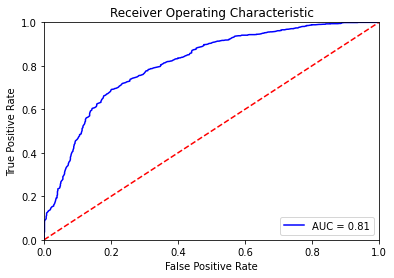

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       801
           1       0.75      0.85      0.79      1170

    accuracy                           0.74      1971
   macro avg       0.73      0.71      0.72      1971
weighted avg       0.74      0.74      0.73      1971

accuracy_rfc:  0.7371892440385591


In [0]:
rfc2 = RandomForestClassifier(n_estimators=500)
print("accuracy_rfc: ", plotROC(rfc2))

## 6.2 LightGBM

In [0]:
from lightgbm import LGBMClassifier

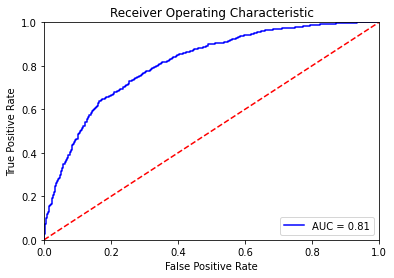

              precision    recall  f1-score   support

           0       0.71      0.63      0.67       801
           1       0.76      0.82      0.79      1170

    accuracy                           0.74      1971
   macro avg       0.74      0.73      0.73      1971
weighted avg       0.74      0.74      0.74      1971

accuracy_lgb:  0.7432775240994419


In [0]:
lgb = LGBMClassifier(objective='binary',
                      learning_rate=0.049,
                      n_estimators=1500,
                      num_leaves=8,
                      min_data_in_leaf=4,
                      max_depth=3,
                      max_bin=41,
                      bagging_fraction=0.845,
                      bagging_freq=5,
                      feature_fraction=0.24,
                      feature_fraction_seed=9,
                      bagging_seed=9,
                      min_sum_hessian_in_leaf=11)
print("accuracy_lgb: ", plotROC(lgb))

Since the LightGBM generates a slightly higher result, we choose LightGBM as our final walgreen-prediction model.

In [0]:
lgb.fit(X_stan, y2)
predictions = lgb.predict_proba(testset)[:, 1]

In [0]:
predictions

array([0.97625893, 0.95371258, 0.98832827])

In [0]:
output = pd.DataFrame({'zipcode': test.zipcode,
                       'probability': predictions})

In [0]:
output

,zipcode,probability
0,14608,0.976259
1,14604,0.953713
2,14614,0.988328


It turns out that three downtown zip codes all have very high probabilities on opening Walgreens, which justifies our previous brand selection model.

# 7. Conclusion 

Thanks for your patience to read through our codebook, we sincerely wish that our explanation of our data analytical process is clear to you. Meanwhile, we wish this codebook serves as a strong appendix to our final pitch deck presentation. 
